In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_repo = 'google/mt5-small'
model_path = '/content/drive/MyDrive/Opus100_DIr/ModelPytorchTransfer/vCuda/MT5_AR_EN.pt'
max_seq_len = 64

# Load Tokenizer & Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
#model = model.cuda()

In [ ]:
model = model.cuda()

In [ ]:
token_ids = tokenizer.encode(
    '<ar> This will be translated to Arabic! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,    372,    669,   1494,    898,    390,  37194,    285,    288,
            259,  62233,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


In [ ]:
dataset = load_dataset("opus100", "ar-en")

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/ar-en/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']
validation = dataset['validation']

In [ ]:
test_dataset[1]['translation']['en']

'The Commission reviewed the data on recruitment and retention difficulties, which it had requested from the organizations.'

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ar': '<ar>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 512)

In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,

      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0,len(dataset) , batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<en> ▁و ▁ ه ذه ؟ </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁And ▁this ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# Constants
n_epochs = 5
batch_size = 16
print_freq = 500
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-50-7d82fc3c8b16>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/62500 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [ ]:
test_sentence ='relational'
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ar',
    tokenizer = tokenizer,
    seq_len = 64,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: relational
Truncated input text: <ar> relational</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
arr = ["أقرب إلى أو مواجهة على نطاق أنظمة أو هياكل"]
for test_sentence in arr :
  print('Raw input text:', test_sentence)

  input_ids = encode_input_str(
      text = test_sentence,
      target_lang = 'en',
      tokenizer = tokenizer,
      seq_len = 64,
      lang_token_map = LANG_TOKEN_MAPPING)
  input_ids = input_ids.unsqueeze(0).cuda()

  print('Truncated input text:', tokenizer.convert_tokens_to_string(
      tokenizer.convert_ids_to_tokens(input_ids[0])))
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)
  strr=''
  # print(output_tokens)
  for token_set in output_tokens:
    strr += tokenizer.decode(token_set, skip_special_tokens=True)
  print(strr)

Raw input text: أقرب إلى أو مواجهة على نطاق أنظمة أو هياكل
Truncated input text: <en> أقرب إلى أو مواجهة على نطاق أنظمة أو هياكل</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Closer to or facing within the scope of regulations, structures or 


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)
strr=''
# print(output_tokens)
for token_set in output_tokens:
  strr += tokenizer.decode(token_set, skip_special_tokens=True)
print(strr)

ثالثاً - العلاقات المرتبطة بالعلاقات


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge
ROUGE = Rouge()


In [ ]:
scores = []
for word_set in validation['translation'] :
  data = word_set['en']

  input_ids = encode_input_str(
    text = data,
    target_lang = 'ar',
    tokenizer = tokenizer,
    seq_len = 64,
    lang_token_map = LANG_TOKEN_MAPPING)

  input_ids = input_ids.unsqueeze(0).cuda()

  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)
  str_out=''
  for token_set in output_tokens:
    str_out += tokenizer.decode(token_set, skip_special_tokens=True)
  reference = word_set['ar']
  scores.append(ROUGE.get_scores(str_out, reference)[0]['rouge-1']['f'])

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
import numpy as np

0.25934834705987947


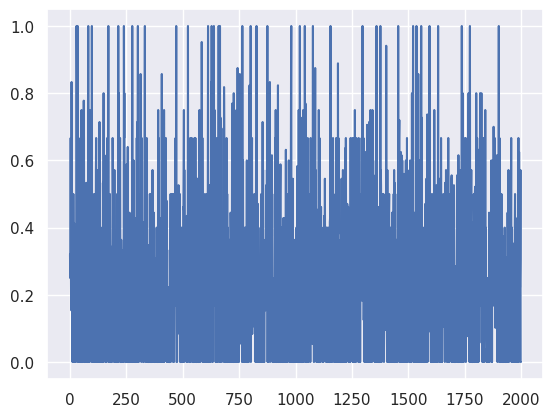

In [ ]:
plt.plot(scores)
print(np.array(scores).mean())

In [ ]:
import nltk
from nltk.corpus import wordnet as wn


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
wn.synsets('abaxial')


[Synset('abaxial.a.01')]

In [ ]:
ele = wn.synset('abaxial.a.01').definition()
print(ele)
input_ids = encode_input_str(
  text = ele,
  target_lang = 'ar',
  tokenizer = tokenizer,
  seq_len = 64,
  lang_token_map = LANG_TOKEN_MAPPING)
print(len(input_ids))
input_ids = input_ids.unsqueeze(0).cuda()
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
print(output_tokens)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

facing away from the axis of an organ or organism
64
tensor([[    0,   259, 15055,   259,   477, 21554, 53286, 29026,  1093,  1698,
           259,   586, 40630,   259, 17912,  2876,  3510, 41045,  2876,   259],
        [    0,   259, 15055,   259,   477, 21554, 53286, 29026,  1093,  1698,
           259,   586, 40630,   259, 17912,  2876,   259, 17912,  2876,   259],
        [    0,   259, 15055,   259,   477, 21554, 53286, 29026,  1093,  1698,
          1021,  8865,   259, 17912,  2876,   259, 17912,  2876,   259, 17912]],
       device='cuda:0')
وهو يواجه بعيداً عن نطاق عضو أو كائن أو 
وهو يواجه بعيداً عن نطاق عضو أو عضو أو 
وهو يواجه بعيداً عن أرض عضو أو عضو أو عضو


In [ ]:
for ele in wn.synset('abaxial.a.01').examples() :
  print(ele)
  input_ids = encode_input_str(
    text = ele,
    target_lang = 'ar',
    tokenizer = tokenizer,
    seq_len = 64,
    lang_token_map = LANG_TOKEN_MAPPING)
  input_ids = input_ids.unsqueeze(0).cuda()
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)

  # print(output_tokens)
  for token_set in output_tokens:
    print(tokenizer.decode(token_set, skip_special_tokens=True))

the abaxial surface of a leaf is the underside or side facing away from the stem
سطح الرصاص الأسفل أو الجانب الذي يواجه بعيداً عن 
سطح الرصاص الأسفل أو الجانب الذي يواجه بعيداً عن ال
سطح الدائرة الجانب الأيسر أو الجانب الذي يواجه بعيدا


In [ ]:
dataset_2 = load_dataset("ccaligned_multilingual", language_code="ar_AR", type="documents")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset ccaligned_multilingual downloaded and prepared to /root/.cache/huggingface/datasets/ccaligned_multilingual/documents-ar_AR-588a624090e9b0a1/1.0.0/6ef3ed542dddb4f7e85e0e082114c8771a2b1f4b585a16d4c6fb60a1e73c6789. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset_2['train'][1]

{'Domain': 'qatardebate.com',
 'Source_URL': 'http://qatardebate.com/international-events/fouth-icard2013/overview',
 'Target_URL': 'http://qatardebate.com/international-events-ar/fouth-icard2013-ar/overview-ar',
 'translation': {'ar_AR': 'نظرة عامة عن المؤتمر _ عن مركز مناظرات قطر|☰القائمة|English|اشترك|🔍|Search|من نحن|عن مؤسسة قطر|عن مركز مناظرات قطر|كلمة المدير التنفيذي|نجاحات بارزة|اتصل بنا|المناظرة وعملية التناظر|تعلم المناظرة|ما هي المناظرة؟|فوائد المناظرة|أبرز المتناظرين القطريين|كيف تصبح مناظراً؟|روابط مهمة|البرامج التعليمية|البرامج المحلية|عنابي المناظرات|التعاونات والشراكات|كيف تبدأ برنامجك الخاص بالمناظرة؟|مدربون|برامج التواصل|عن برامج التواصل|سفراء مركز مناظرات قطر|أكاديمية النخبة|الأخبار|معرض الصور|فعاليات دولية|البطولات الدولية لمناظرات الجامعات باللغة العربية|البطولات الدولية لمناظرات المدارس باللغة العربية|المؤتمر الدولي الرابع|البطولة الدولية للمدارس 2010|إصدارات|إصدارات|أخبار مناظرات قطر|المدخل إلى فن المناظرة|قاموس مصطلحات المناظرة|المرشد|المركز الإعلامي|الأخبار|الفع

In [ ]:
print(model.config)

MT5Config {
  "_name_or_path": "google/mt5-small",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 250102
}



In [ ]:
model2_repo = 'google/mt5-large'

In [ ]:
model2 = AutoModelForSeq2SeqLM.from_pretrained(model2_repo)

In [ ]:
print(model2.config.max_length)

20
